In [1]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.corpus import stopwords
from nltk import pos_tag # 품사 분류
from nltk.tokenize import word_tokenize # 단어 토큰화
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.regression import *
from torchmetrics.classification import *
from torchmetrics.functional.regression import r2_score
from torchmetrics.functional.classification import f1_score

import sys
sys.path.append('C:\VSCode\K-Digital Training\MyModule')
from KDTModule import *

import nltk
# nltk.download('stopwords') # 불용어 목록 다운로드 해야 함
# nltk.download('punkt') # 토큰화 할때 필요
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')

In [2]:
torch.manual_seed(1) # 시드 설정

# 데이터 불러오기
df = pd.read_csv('twitter/Twitter_Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [3]:
# 결측치 확인
print(df.isna().sum())
print('--------------')
# 결측치 제거
df = df.dropna().reset_index(drop=True)
print(df.isna().sum())

clean_text    4
category      7
dtype: int64
--------------
clean_text    0
category      0
dtype: int64


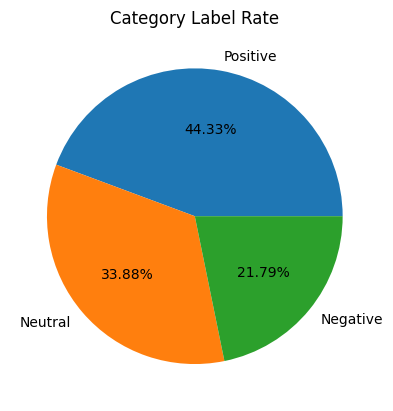

In [4]:
# 각 레이블의 빈도수 시각화
plt.pie(df['category'].value_counts(), autopct= '%.2f%%', labels = ['Positive', 'Neutral', 'Negative'])
plt.title('Category Label Rate')
plt.show()

In [5]:
total_token_list = []
stop_words = set(stopwords.words('english'))
for text in df['clean_text']:
    # 소문자 변환
    text = text.lower()
    # 특수문자 및 숫자 제거
    text = re.sub(r'[^a-z\s]', '', text)
    # 토큰화
    tokens = word_tokenize(text) # 단어별로 리스트에 담기
    # 불용어 제거
    tokens = ' '.join([word for word in tokens if word not in stop_words])
    total_token_list.append(tokens)

In [6]:
total_token_list

['modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state business exit psus temples',
 'talk nonsense continue drama vote modi',
 'say vote modi welcome bjp told rahul main campaigner modi think modi relax',
 'asking supporters prefix chowkidar names modi great service confusion read crustal clear crass filthy nonsensical see abuses coming chowkidars',
 'answer among powerful world leader today trump putin modi may',
 'kiya tho refresh maarkefir comment karo',
 'surat women perform yagna seeks divine grace narendra modi become',
 'comes cabinet scholars like modi smriti hema time introspect',
 'upcoming election india saga going important pair look current modi leads govt elected deal brexit combination weekly looks juicy bears imho',
 'gandhi gay modi',
 'things like demonetisation gst goods services taxthe upper castes would sort either view favourably say need give time castes like dalits muslims modi constituenc

In [7]:
vectorizer = CountVectorizer(binary=True, max_features=8000)

In [8]:
X = vectorizer.fit_transform(total_token_list)

In [9]:
vectorizer.get_feature_names_out()

array(['aab', 'aadhaar', 'aadhar', ..., 'zero', 'zindabad', 'zone'],
      dtype=object)

In [10]:
# Step 4: 결과를 데이터프레임으로 변환 (각 열이 단어, 각 행이 문서)
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 결과 확인
df_bow.head()

,aab,aadhaar,aadhar,aadmi,aage,aaj,aajtak,aalo,aam,aane,...,yrs,ysrcp,yup,yuva,zeal,zealand,zee,zero,zindabad,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_bow['answer_label'] = df['category']
df_bow['answer_label'] = df_bow['answer_label'].replace(-1,2)
df_bow

,aab,aadhaar,aadhar,aadmi,aage,aaj,aajtak,aalo,aam,aane,...,ysrcp,yup,yuva,zeal,zealand,zee,zero,zindabad,zone,answer_label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
162965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
162966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
162967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [12]:
featureDF = df_bow.iloc[:,:-1]
targetDF = df_bow.loc[:,['answer_label']]

In [13]:
# train, valid, test 분리
train_inputDF, test_inputDF, train_targetDF, test_targetDF = train_test_split(featureDF, targetDF,
                                                                                train_size = 0.8,
                                                                                stratify = targetDF,
                                                                                random_state = 42)
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                                train_size = 0.8,
                                                                                stratify = train_targetDF,
                                                                                random_state = 42)

In [14]:
print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (104300, 8000), target : (104300, 1)
[valid] input : (26075, 8000), target : (26075, 1)
[test] input : (32594, 8000), target : (32594, 1)


In [15]:
# 데이터셋 생성
trainDS = CustomDataset(train_inputDF, train_targetDF)
validDS = CustomDataset(valid_inputDF, valid_targetDF)

# 데이터셋 속성
print(f"trainDS shape : ({trainDS.n_rows}, {trainDS.n_features})")
print(f"testDS : ({validDS.n_rows}, {validDS.n_features})")

# 데이터로더 인스턴스 생성
trainDL = DataLoader(trainDS, batch_size=32)
validDL = DataLoader(validDS, batch_size=32)

trainDS shape : (104300, 8000)
testDS : (26075, 8000)


In [16]:
# 모델 인스턴스 생성
model = LinearModel(input_in=8000, output_out=3,
                  hidden_list=[100, 70, 40], act_func=F.relu, model_type='multiclass')
print(model)
summary(model)

LinearModel(
  (input_layer): Linear(in_features=8000, out_features=100, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=100, out_features=70, bias=True)
    (1): Linear(in_features=70, out_features=40, bias=True)
  )
  (output_layer): Linear(in_features=40, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Param #
LinearModel                              --
├─Linear: 1-1                            800,100
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       7,070
│    └─Linear: 2-2                       2,840
├─Linear: 1-3                            123
Total params: 810,133
Trainable params: 810,133
Non-trainable params: 0

In [18]:
model2 = LSTMModel(input_size=8000, output_size=3,
                  hidden_list=[128, 64], act_func=nn.ReLU(), model_type='multiclass')

In [19]:
# 옵티마이저 (모델의 가중치 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.1)
# 가중치, 절편을 전달하고 학습률을 설정

# 모델 훈련
EPOCH = 2
SAVE_PATH = r'C:\VSCode\K-Digital Training\김소현 강사님\프로젝트\4번째 프로젝트\model'
result = training(trainDL, validDL, model2, 'multiclass', adam_optim, EPOCH,
                  endurance_cnt=5, num_classes=3, SAVE_PATH=SAVE_PATH)

IndexError: too many indices for tensor of dimension 2